In [6]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

# define els_obs as an object containing x_normals and y_normals with same as size as n_pts
class els_normals:
    def __init__(self, els, n_pts):
        x_normals = els.x_normals
        y_normals = els.y_normals
        x_shears = els.x_shears
        y_shears = els.y_shears

        self.x_normals = np.zeros(n_pts * len(x_normals))
        self.y_normals = np.zeros(n_pts * len(x_normals))
        self.x_normals[0:n_pts] = x_normals[0]
        self.y_normals[0:n_pts] = y_normals[0]
        self.x_normals[n_pts : 2 * n_pts] = x_normals[1]
        self.y_normals[n_pts : 2 * n_pts] = y_normals[1]
        self.x_normals[2 * n_pts :] = x_normals[2]
        self.y_normals[2 * n_pts :] = y_normals[2]

        self.x_shears = np.zeros(n_pts * len(x_normals))
        self.y_shears = np.zeros(n_pts * len(x_normals))
        self.x_shears[0:n_pts] = x_shears[0]
        self.y_shears[0:n_pts] = y_shears[0]
        self.x_shears[n_pts : 2 * n_pts] = x_shears[1]
        self.y_shears[n_pts : 2 * n_pts] = y_shears[1]
        self.x_shears[2 * n_pts :] = x_shears[2]
        self.y_shears[2 * n_pts :] = y_shears[2]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


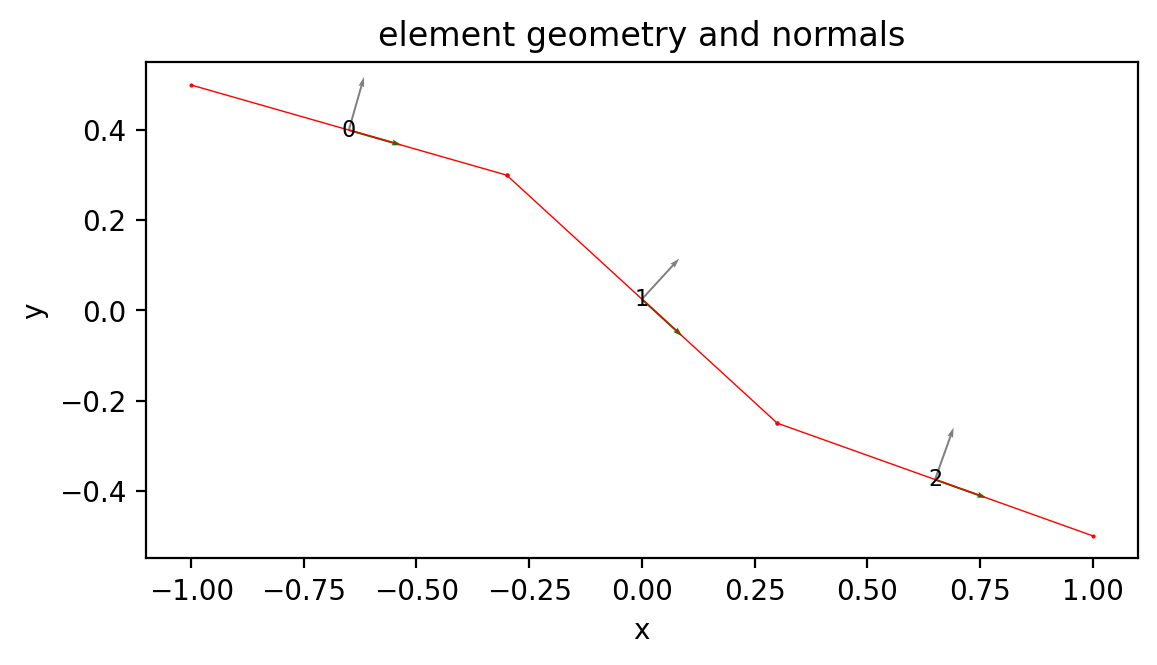

In [7]:
els = bemcs.initialize_els()
# els.x1 = np.array([-1.0, 0.0, 0.0])
# els.y1 = np.array([0.5, 0.5, -0.5])
# els.x2 = np.array([0.0, 0.0, 1.0])
# els.y2 = np.array([0.5, -0.5, -0.5])

els.x1 = np.array([-1.0, -0.3, 0.3])
els.y1 = np.array([0.5, 0.3, -0.25])
els.x2 = np.array([-0.3, 0.3, 1.0])
els.y2 = np.array([0.3, -0.25, -0.5])

# Slip imposed at central nodes of each patch (these are in x,y coordinates)
slip_vector_x = np.array([0.3, 0.8, 0.3])
slip_vector_y = np.array([0.1, 0.0, 0.1])
# slip_vector_x = np.random.rand(3)
# slip_vector_y = np.random.rand(3)

bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

In [8]:
# Design matrices (in x, y coordinates) for slip and slip gradients at each 3qn
stride = 6
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")
design_mat = np.zeros((n_els * stride, n_els * stride))

# Set boundary conditions
# Slip -or- slip gradients at the boundaries (we set them to 0 here)
bc_vec = np.zeros((n_els * stride))
bc_vec[0] = 0.0
bc_vec[1] = 0.0
bc_vec[-1] = 0.0
bc_vec[-2] = 0.0
bc_vec[2::stride] = slip_vector_x
bc_vec[3::stride] = slip_vector_y

# Populate design matrix
# Boundary nodes
design_mat[0:2, :] = slip_mat[0:2]
design_mat[-2:, :] = slip_mat[-2:, :]

# Patch center nodes
design_mat[2::stride, :] = slip_mat[2::stride, :]
design_mat[3::stride, :] = slip_mat[3::stride, :]

# Overlapping interior nodes (apply slip continuity and smoothness)
# Slip continuity (x component)
design_mat[4:-7:stride, :] = slip_mat[4:-7:stride, :] - slip_mat[6:-5:stride, :]

# Slip continuity (y component)
design_mat[5:-6:stride, :] = slip_mat[5:-6:stride, :] - slip_mat[7:-4:stride, :]

# Smoothness
# x component
design_mat[6:-5:stride, :] = (
    slip_gradient_mat[4:-7:stride, :] - slip_gradient_mat[6:-5:stride, :]
)
# y component
design_mat[7:-4:stride, :] = (
    slip_gradient_mat[5:-6:stride, :] - slip_gradient_mat[7:-4:stride, :]
)

# Solve for quadratic node coefficients (in local (s, n) coordinates)
coeffs = np.linalg.inv(design_mat) @ bc_vec

# Extract (s, n) components and store them in two separate vectors
coeffs_s = np.zeros((3 * n_els))
coeffs_n = np.zeros((3 * n_els))
for i in range(n_els):
    coeffs_s[3 * i : 3 * (i + 1)] = coeffs[stride * i : stride * i + 3]
    coeffs_n[3 * i : 3 * (i + 1)] = coeffs[stride * i + 3 : stride * (i + 1)]

# Plot Slip along the fault

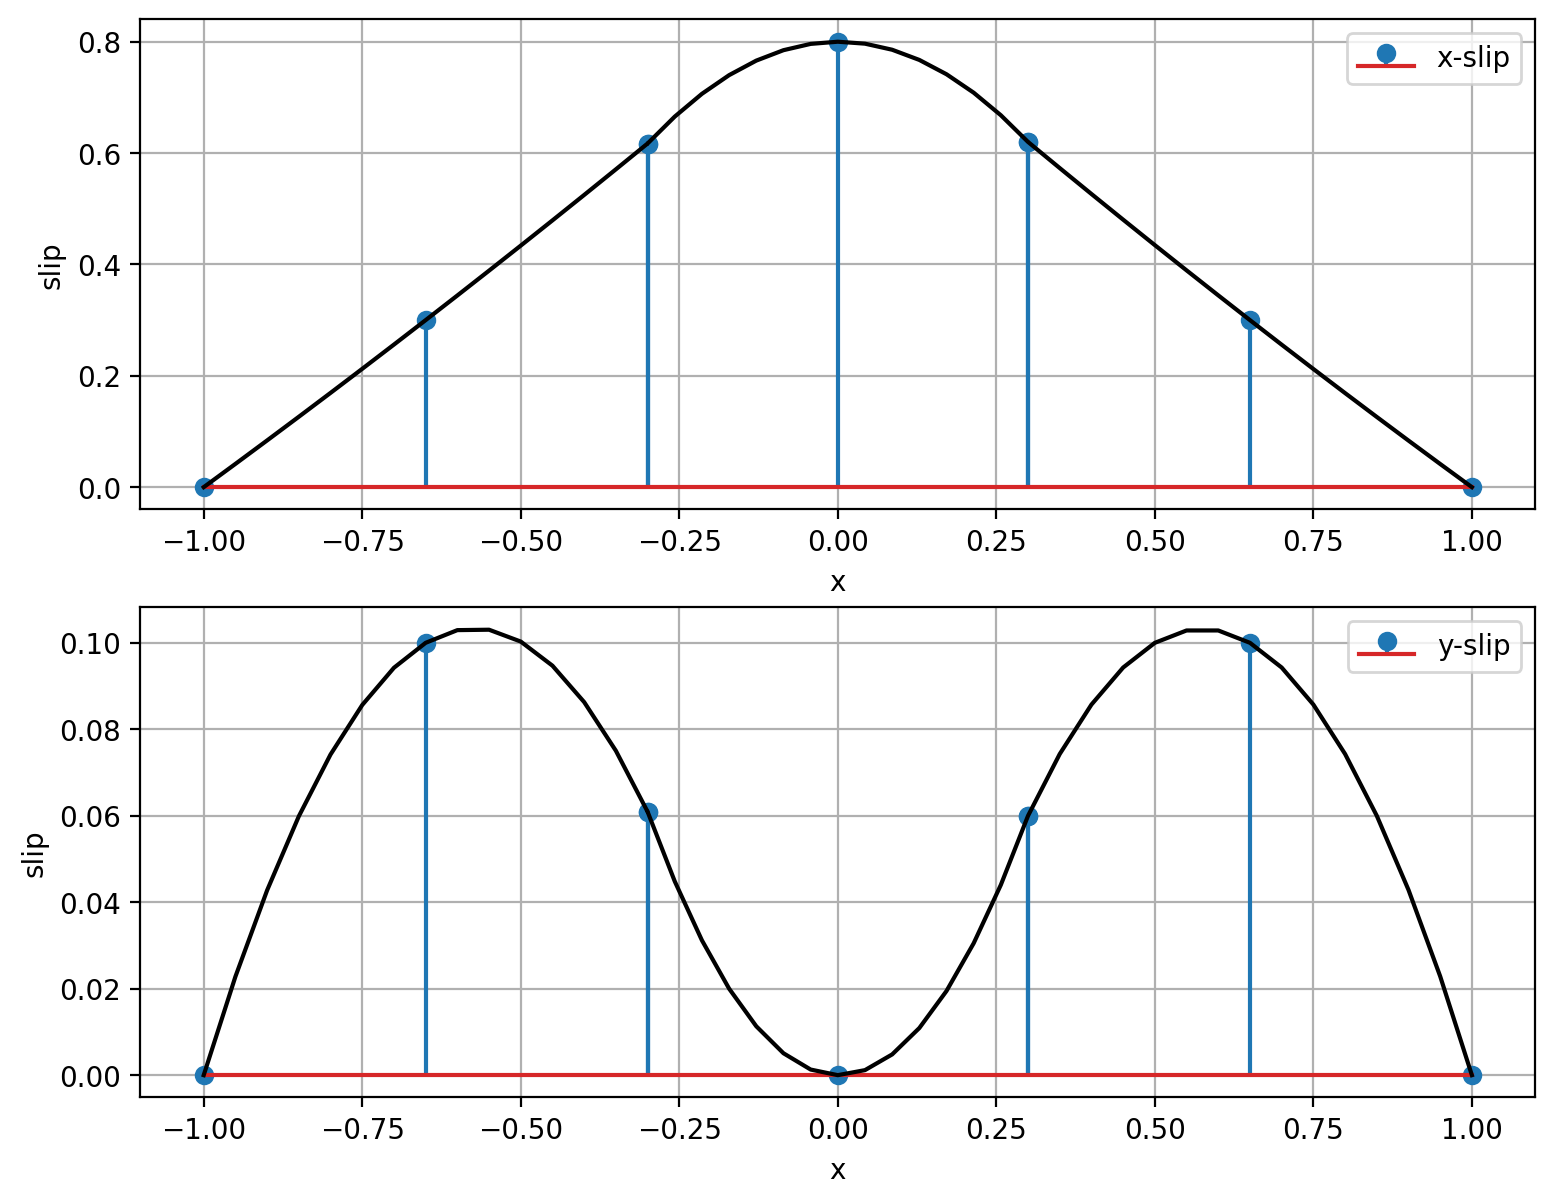

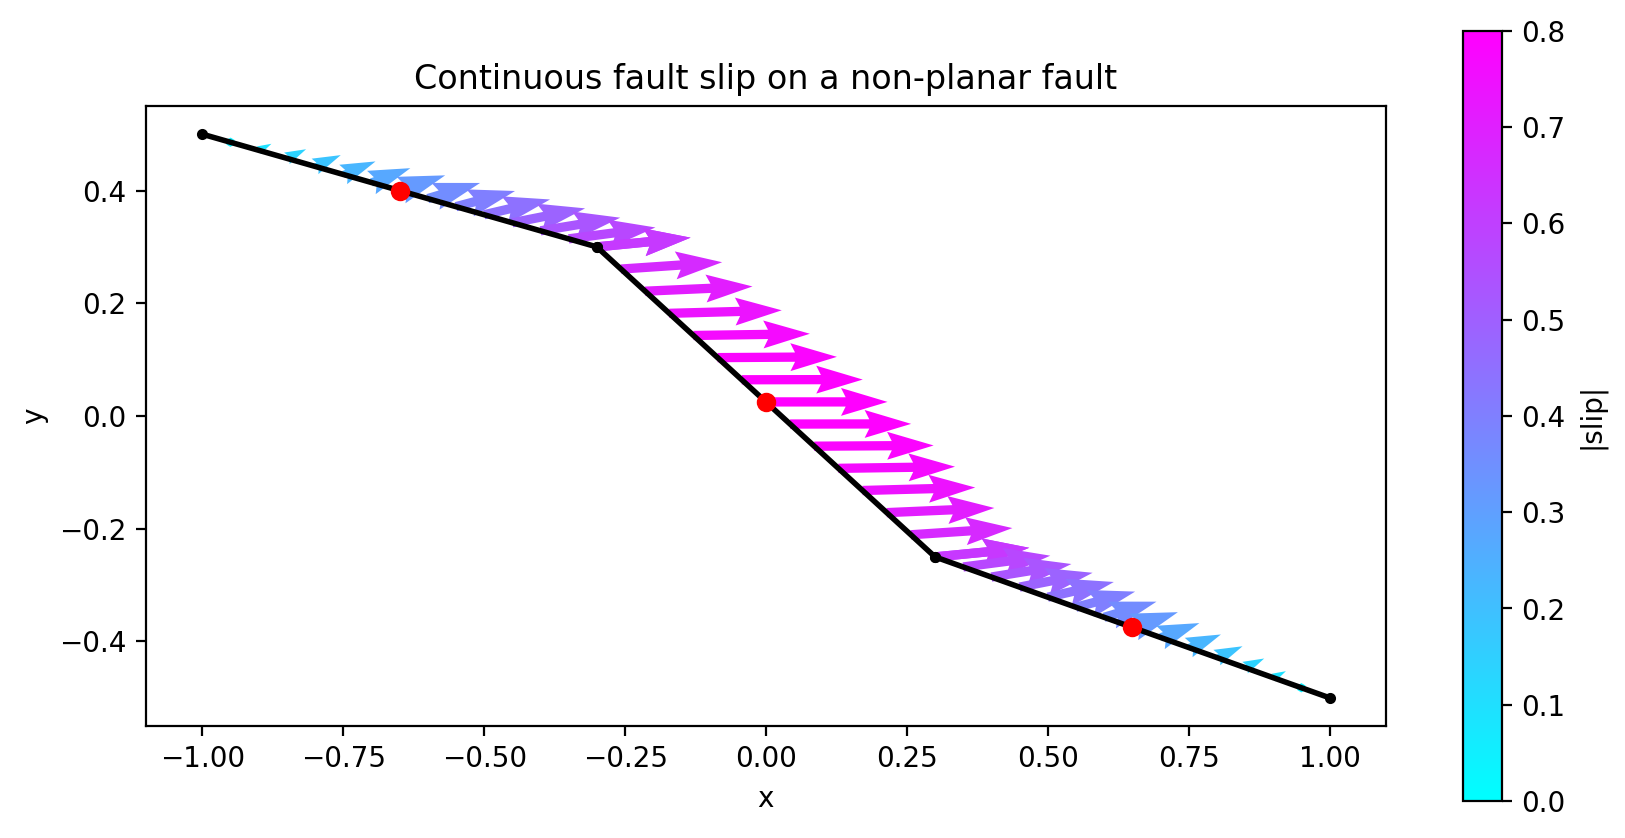

In [9]:
# provide number of points per fault element
n_eval = 15

# calculate slip at all nodes
x_nodes = np.zeros((3 * n_els, 1))
x_nodes[0::3, 0] = els.x1
x_nodes[2::3, 0] = els.x2
x_nodes[1::3, 0] = els.x_centers
fault_slip = slip_mat @ coeffs
fault_slip_x_nodes = fault_slip[0::2]
fault_slip_y_nodes = fault_slip[1::2]

x_obs, y_obs, fault_slip_x, fault_slip_y = bemcs.get_slipvector_on_fault(
    els, coeffs, n_eval
)

# plot as a line plot
plt.figure(figsize=(9, 7))
plt.subplot(2, 1, 1)
plt.stem(x_nodes, fault_slip_x_nodes, "o", label="x-slip")
plt.plot(x_obs, fault_slip_x, "k-")
plt.grid()
plt.legend()
plt.xlabel("x")
plt.ylabel("slip")
plt.subplot(2, 1, 2)
plt.stem(x_nodes, fault_slip_y_nodes, "o", label="y-slip")
plt.plot(x_obs, fault_slip_y, "k-")
plt.grid()
plt.legend()
plt.xlabel("x")
plt.ylabel("slip")
plt.show()

# plot as quiver in map/cross-sectional view
plt.figure(figsize=(10, 5))
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-", linewidth=2)
plt.plot(els.x_centers, els.y_centers, "ro")
plt.quiver(
    x_obs,
    y_obs,
    fault_slip_x,
    fault_slip_y,
    np.sqrt(fault_slip_x**2 + fault_slip_y**2),
    cmap="cool",
)
plt.gca().set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="|slip|")
plt.title("Continuous fault slip on a non-planar fault")
plt.show()

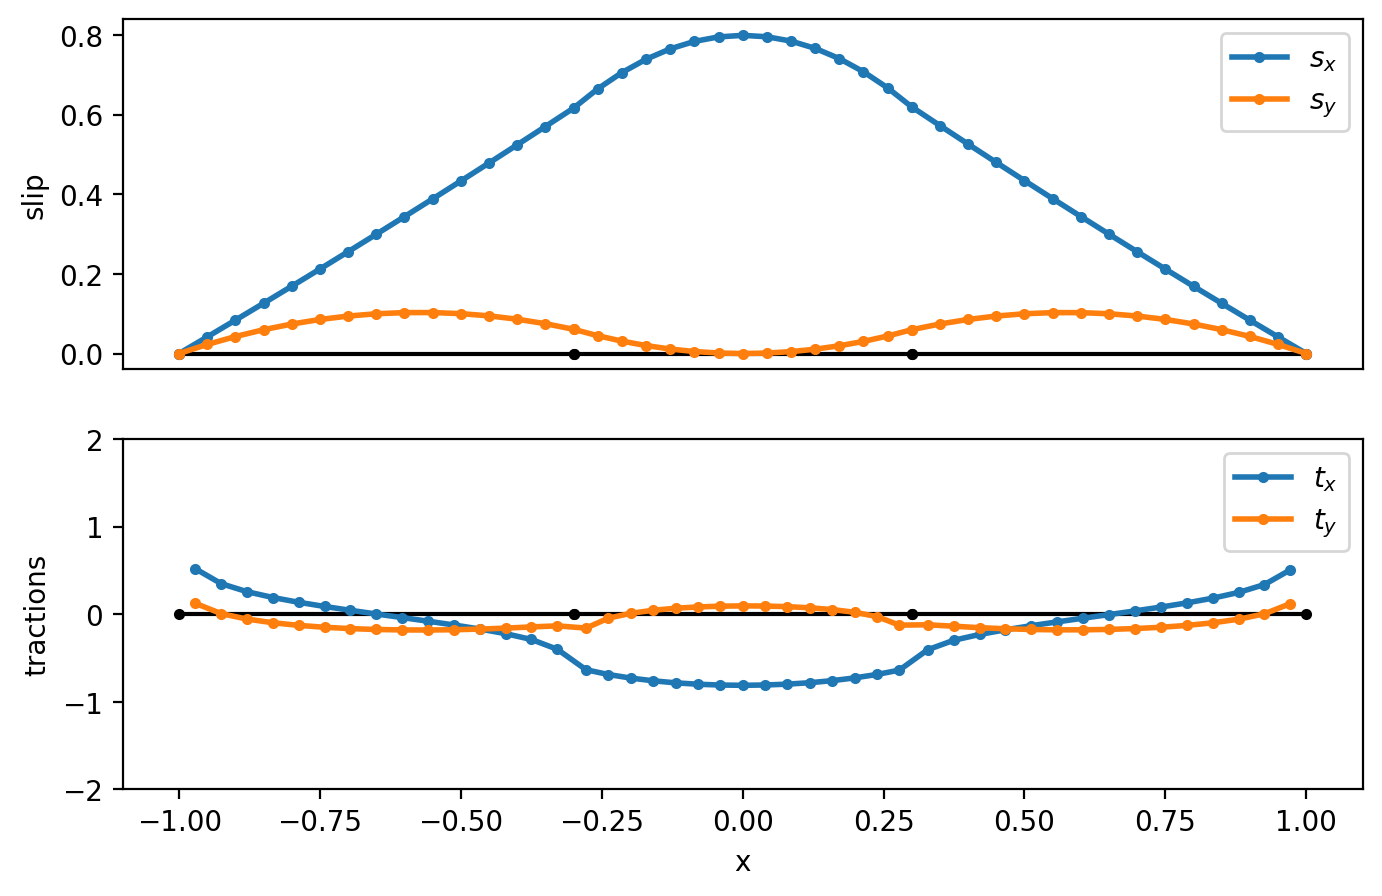

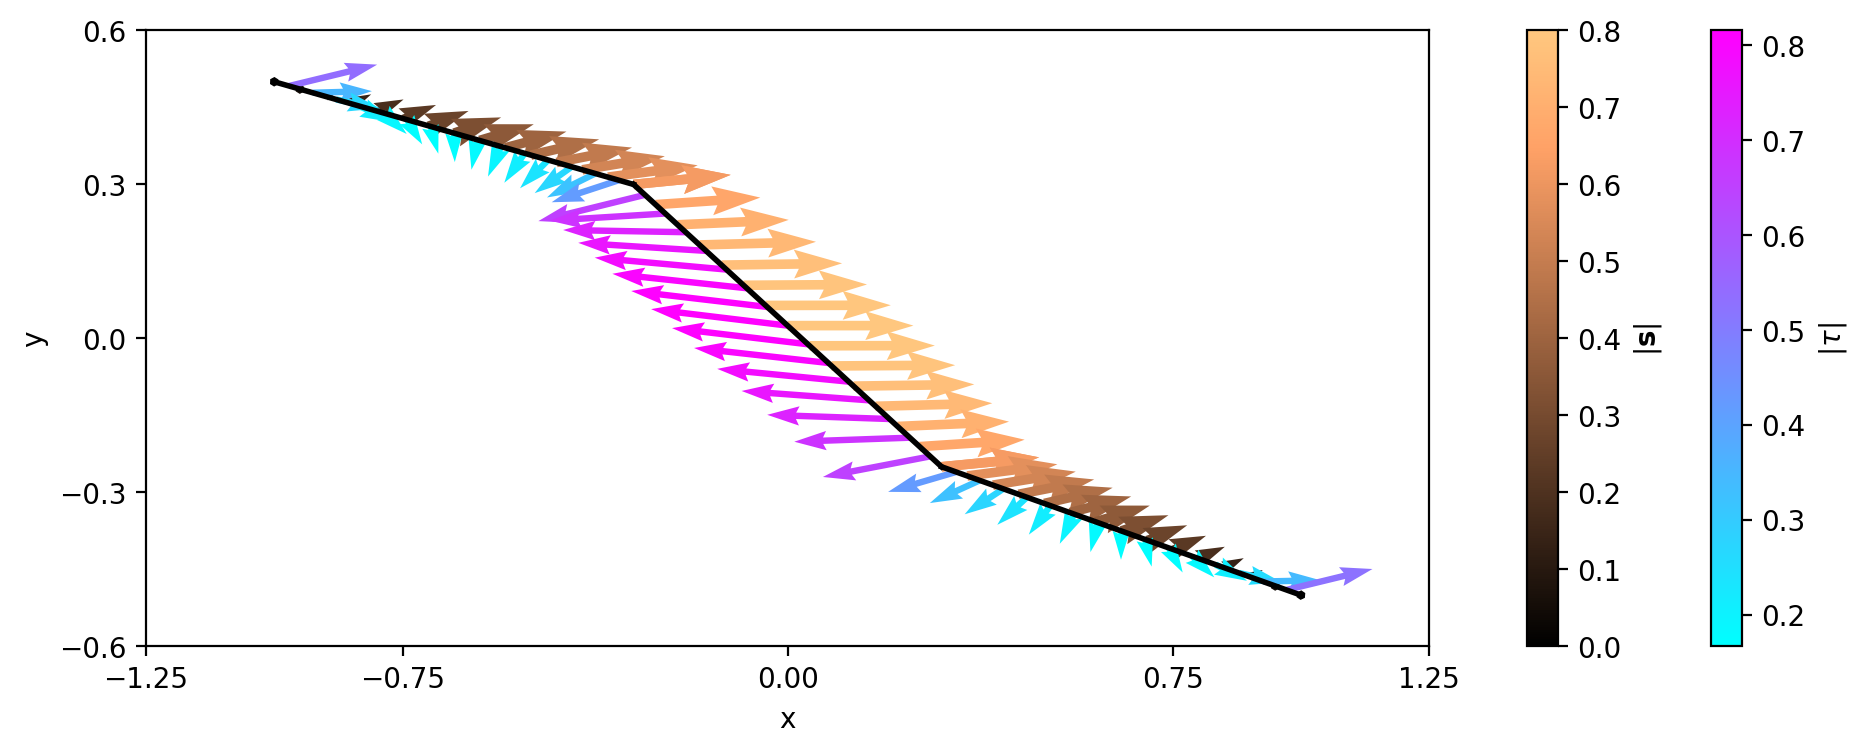

In [13]:
# Compute displacement and stress kernels
# Elastic parameters
mu = 1
nu = 0.25

# Compute displacements along a line
n_pts = 15
dr = 3e-2

els_obs = els_normals(els, n_pts)

x_plot = np.hstack(
    (
        np.linspace(
            els.x1[0] + dr * els.x_shears[0], els.x2[0] - dr * els.x_shears[0], n_pts
        ),
        np.linspace(
            els.x1[1] + dr * els.x_shears[1], els.x2[1] - dr * els.x_shears[1], n_pts
        ),
        np.linspace(
            els.x1[2] + dr * els.x_shears[2], els.x2[2] - dr * els.x_shears[2], n_pts
        ),
    )
).reshape(-1, 1)
y_plot = np.hstack(
    (
        np.linspace(
            els.y1[0] + dr * els.y_shears[0], els.y2[0] - dr * els.y_shears[0], n_pts
        ),
        np.linspace(
            els.y1[1] + dr * els.y_shears[1], els.y2[1] - dr * els.y_shears[1], n_pts
        ),
        np.linspace(
            els.y1[2] + dr * els.y_shears[2], els.y2[2] - dr * els.y_shears[2], n_pts
        ),
    )
).reshape(-1, 1)

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_plot, y_plot, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_plot, y_plot, els, mu, nu, flag="normal"
)

# Compute displacement and stresses (we will plot it later)
_, _, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)

# compute traction kernels
tractionkernels_s = bemcs.get_traction_kernels(els_obs, kernels_s, flag="global")
tractionkernels_n = bemcs.get_traction_kernels(els_obs, kernels_n, flag="global")

# tractions
tx = tractionkernels_s[0] @ coeffs_s + tractionkernels_n[0] @ coeffs_n
ty = tractionkernels_s[1] @ coeffs_s + tractionkernels_n[1] @ coeffs_n

plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [0, 0], "k.-")
plt.plot(x_obs, fault_slip_x, ".-", linewidth=2, label="$s_x$")
plt.plot(x_obs, fault_slip_y, ".-", linewidth=2, label="$s_y$")
plt.legend()
plt.xticks(())
plt.ylabel("slip")
plt.subplot(2, 1, 2)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [0, 0], "k.-")
plt.plot(x_plot, tx, ".-", linewidth=2, label="$t_x$")
plt.plot(x_plot, ty, ".-", linewidth=2, label="$t_y$")
plt.legend()
plt.xlabel("x")
plt.ylabel("tractions")
plt.ylim(-2, 2)
plt.show()

plt.figure(figsize=(14, 4))
# plt.figure(figsize=(8, 6))

for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-", linewidth=2)
# plt.plot(els.x_centers, els.y_centers, "ro")
q_slip = plt.quiver(
    x_obs,
    y_obs,
    fault_slip_x,
    fault_slip_y,
    np.sqrt(fault_slip_x**2 + fault_slip_y**2),
    cmap="copper",
)
q_traction = plt.quiver(
    x_plot,
    y_plot,
    tx,
    ty,
    np.sqrt(tx**2 + ty**2),
    cmap="cool",
    width=0.005,
)
# plt.gca().set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([-1.25, 1.25])
plt.ylim([-0.6, 0.6])
plt.xticks([-1.25, -0.75, 0, 0.75, 1.25])
plt.yticks([-0.6, -0.3, 0.0, 0.3, 0.6])
plt.colorbar(q_traction, label="$|\\tau|$", pad=-0.05)
plt.colorbar(q_slip, label="$|\mathbf{s}|$")
plt.gca().set_aspect("equal", adjustable="box")
# plt.savefig("spatially_smooth_slip_tractions_quiver.pdf")
plt.show()